# Optical microscope imaging of particles inside a capilary.

**In this notebook, we perform bright field optical microscope image formation simulation of small particles dispersed in water and viewed inside a capillary of finite thickness.**

We simulate how the microscope images a particle depending on the distance from the focal plane of the lens using Mie scattering theory and principles of Fourier optics to construct the image. We define lens magnification and the numerical aperture (NA) to simulate lens diffraction effects. The imaging model is valid for any kind of microscope (magnification and objective NA), but we simplify the computation by restricting to Koehler illumination at small condenser NA). We also assume single and weak scattering regime. Therefore, the imaging model is valid for small particles with weak contrast and at small concentrations. For any given z-position within the channel, we compute a single particle image and construct a FFT lookup table. We store Fourier coefficients of the single particle image because (apart from phase shift) these do not change with time. This allow us to draw a particle image at any coordinate in the XY plane by means of image translation performed in reciprocal space (multiplication of LUT with a phase shift matrix) to obtain accurate and numerically efficient image translation. Because of single scattering aproximation, we can then contruct the multi-particle image by sumation over single particle images.

## Library

Please install the following packages

* matplotlib
* miepython
* mlx (optional)
* cupy (optional)
* numba (optional)
* numpy
* scipy

Next, you can change the default library settings to improve computation speed. Set whether we use single precision, and whether we enable threading and determine number of threads used. Best performance is usually obtained setting number of threads to the total number of performance cores of your CPU.


In [16]:
# Library settings and imports

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time, os
import warnings

#: whether to use Apple mlx library to compute on GPU (Apple silicon)
USEMLX = False

#: whether to use CuPy for Nvidia GPUs 
USECUPY = False

#: whether to use numba-compiled code for speedup.
USENUMBA = True

#: which library is being used for FFT calculation. 
FFTLIB = "scipy" # "scipy", "numpy" or "mlx"

#: Computation precision. Note that if MLX (or CuPy) is used, it is always single precision
PRECISION = "single" # single or double

#: whether to use fast math (numba)
NBFASTMATH = True

#: numba's compile target argument for vectorize and guvectorize functions.
NBTARGET = "cpu" # "parallel", "cpu" or "gpu" (if supported)

#: how many threads are being used when computing FFTs (only for scipy)
NUM_FFTTHREADS = 4

#: how many threads are being used when computing numba code
NUM_NBTHREADS = 4

#: whether to save matplitlib figures
SAVE_FIGS = False

# for internal use, do not change, determines whether lib imports and numba compilation is complete
_LIB_OK = False #whether libs are imported
_NUMBA_OK = False # whether numba compiles
_FFT_OK = False # whether fft lib compiles
_CAMERA_OK = False # whether camera model is set
_IMAGING_OK = False # whether imaging model is set
_LUT_OK = False # whether lookup tables are computed
_EXPERIMENT_OK = False # whether experimental conditions are set
_SIMULATOR_OK = False # whether the simulator is all set

In [17]:
# Computed constants below. Do not modify!
#-----------------------------------------
if USEMLX:
    import mlx.core as mx
    if PRECISION == "double":
        warnings.warn("MLX is being used, setting single precision", UserWarning)
    PRECISION = "single" #force single precision

if USECUPY:
    import cupy as cp
    if PRECISION == "double":
        warnings.warn("CuPy is being used, setting single precision", UserWarning)
    PRECISION = "single" #force single precision

if USENUMBA:
    import numba as nb
    nb.set_num_threads(NUM_NBTHREADS)

if FFTLIB == "scipy":
    import scipy as sp
    
elif FFTLIB == "mlx":
    import mlx.core as mx
elif FFTLIB != "numpy":
    raise ValueError("Invalid fftlib name")

os.environ["MIEPYTHON_CACHE"] = "0"
os.environ["MIEPYTHON_FASTMATH"] = "1"
os.environ["MIEPYTHON_TARGET"] = "parallel"
    
if PRECISION == "single":
    os.environ["MIEPYTHON_USE_DOUBLE"] = "0"
    if USENUMBA:
        NBFLOAT = nb.float32
        NBCOMPLEX = nb.complex64
        NBUINT = nb.uint16
    CDTYPE = np.complex64
    FDTYPE = np.float32
    UDTYPE = "uint16"
elif PRECISION == "double":
    os.environ["MIEPYTHON_USE_DOUBLE"] = "1"
    if USENUMBA:
        NBFLOAT = nb.float64
        NBCOMPLEX = nb.complex128
        NBUINT = nb.uint16
    CDTYPE = np.complex128
    FDTYPE = np.float64
    UDTYPE = "uint16"
else:
    raise ValueError("Invalid precision name")

import miepython as mie

def bar(i,count):
    i = int(i/count*50)
    return "|"+ "="*i + "-"*(50-i)+ "|"

def print_progress(i, count = 100, text = "Progress..."):
    def _t(s):
        m = s/60.
        h = m/60.
        if h> 1.:
            return h,"h"
        elif m > 1.:
            return m, "m"
        else:
            return s,"s"      
    if i == 0:
        print_progress.t0 = time.time()
        print(bar(i,count), f"{100*i/count:.1f} %", end = "\r")                      
    else:
        t1 = time.time() 
        if count == i:
            dt = t1-print_progress.t0
            dt,unit = _t(dt)
            print(bar(i,count), f"{100*i/count:02.1f} % Done in {dt:>4.1f} {unit}")
        else:
            ETA = (t1 - print_progress.t0)*(count - i)/i
            ETA,unit = _t(ETA)
            print(bar(i,count), f"{100*i/count:>4.1f} % ETA: {ETA:>4.1f} {unit}", end = "\r")
    
def print_line(symbol = "-", count = 72):
    print(symbol * count)
    
def print_settings():
    print("Library settings")
    print_line("-")
    print(f"Using MLX:           {USEMLX}")
    print(f"Using Numba:         {USENUMBA}")
    print(f"FFT library:         '{FFTLIB}'")
    print(f"Precission:          '{PRECISION}'")
    print(f"Using fastmath:      {NBFASTMATH}")
    print(f"Numba target:        '{NBTARGET}'")
    print(f"Num threads (FFT):   {NUM_FFTTHREADS}")
    print(f"Num threads (Numba): {NUM_NBTHREADS}")
    print_line("=")

def vectorize(f,*args,**kwargs):
    if USENUBA:
        f = nb.vectorize(*args,**kwargs)(f)
    return f

def assert_lib_ok():
    """Returns whether library is properly compiled"""
    assert _LIB_OK and _NUMBA_OK and _FFT_OK

def is_power_of_two(i):
    return 2**int(np.log2(i)) == i

_LIB_OK = True

print_settings()

print("numpy", np.__version__)
print("scipy", sp.__version__)
print("numba", nb.__version__)
print("miepython", mie.__version__)
if USEMLX == True:
    print("mlx", mx.__version__)
if USECUPY == True:
    print("cupy", cp.__version__)



Library settings
------------------------------------------------------------------------
Using MLX:           False
Using Numba:         True
FFT library:         'scipy'
Precission:          'single'
Using fastmath:      True
Numba target:        'cpu'
Num threads (FFT):   4
Num threads (Numba): 4
numpy 2.2.5
scipy 1.16.2
numba 0.61.2
miepython 3.0.2


In [18]:
# Compiled numba code

assert _LIB_OK

if USENUMBA:
    @nb.jit([(NBCOMPLEX[:,:],NBCOMPLEX[:],nb.boolean[:,:])])
    def fill(im,data,mask):
        k = 0
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                if mask[i,j] == True:
                    im[i,j] = data[k]
                    k+=1
                else:
                    im[i,j] = 0
                    
    @nb.guvectorize([(nb.boolean[:,:],NBCOMPLEX[:],NBCOMPLEX[:,:])],"(n,m),(k)->(n,m)",target = "parallel")
    def fill_vec(mask,data,im):
        fill(im,data,mask)
    
    @nb.vectorize([NBFLOAT(NBCOMPLEX)],target = "parallel")
    def abs2(a):
        return a.real**2 + a.imag**2
    
    @nb.guvectorize([(NBFLOAT[:],NBFLOAT[:],NBFLOAT[:])], "(n),(n)->()", 
                    fastmath = True, cache = True, target = "parallel")
    def dot(a,b, out):
        tmp = 0
        for i in range(3):
            tmp += a[i] * b[i]
        out[0] = tmp

    @nb.vectorize([NBCOMPLEX(NBFLOAT)], target = "parallel", fastmath = True)
    def expj(x):
        return np.exp(1j*x)

    # numba does not support np.clip, but we need it in sensor_image function
    @nb.jit([NBFLOAT(NBFLOAT,NBFLOAT,NBFLOAT)])
    def clip(a,low,high):
        if a < low:
            return low
        if a > high:
            return high
        else:
            return a

else:
    def fill(im,data,mask):
        im[...] = 0.
        im[mask] = data
        return im

    def fill_vec(mask, data, out = None):
        if out is None:
            out = np.empty(mask.shape, data.dtype)
        out[...] = 0.
        out[...,mask] = data
        return out  

    def abs2(a,out = None):
        out = np.abs(a, out = out)
        out *= out
        return out

    def dot(a,b):
        return (a*b).sum(axis = -1)     

    def expj(x, out = None):
        return np.exp(1j*x, out = out)

    def clip(a,low, high):
        return np.clip(a,low,high)

_NUMBA_OK = True

In [19]:
# FFT functions

assert _LIB_OK

def _rfft2_mlx(x, **kwargs):
    norm = kwargs.pop("norm", "backward")
    if norm == "ortho":
        norm = 1/(x.shape[-1] * x.shape[-2])**0.5
    elif norm == "forward":
        norm = 1/(x.shape[-1] * x.shape[-2])
    else:
        norm = 1.
    x = mx.array(x)
    out = mx.fft.rfft2(x,**kwargs) * norm
    mx.eval(out)
    return np.array(out,copy=False)


def _rfft2_cupy(x, **kwargs):
    norm = kwargs.pop("norm", "backward")
    if norm == "ortho":
        norm = 1/(x.shape[-1] * x.shape[-2])**0.5
    elif norm == "forward":
        norm = 1/(x.shape[-1] * x.shape[-2])
    else:
        norm = 1.
        
    x = cp.asarray(x)
    out = cp.fft.rfft2(x, **kwargs)*norm

    
    return out.get()



def _fft2_mlx(x,**kwargs):
    norm = kwargs.pop("norm", "backward")
    if norm == "ortho":
        norm = 1/(x.shape[-1] * x.shape[-2])**0.5
    elif norm == "forward":
        norm = 1/(x.shape[-1] * x.shape[-2])
    else:
        norm = 1.
    x = mx.array(x)
    out = mx.fft.fft2(x,**kwargs) * norm
    mx.eval(out)
    return np.array(out,copy=False)

def _fft2_cupy(x, **kwargs):
    norm = kwargs.pop("norm", "backward")
    if norm == "ortho":
        norm = 1/(x.shape[-1] * x.shape[-2])**0.5
    elif norm == "forward":
        norm = 1/(x.shape[-1] * x.shape[-2])
    else:
        norm = 1.
        
    x = cp.asarray(x)
    out = cp.fft.fft2(x, **kwargs)*norm
    return out.get()
    

def _irfft2_mlx(x, **kwargs):
    norm = kwargs.pop("norm", "backward")
    if norm == "ortho":
        1/0 
    elif norm == "forward":
        1/0
    else:
        norm = 1.
    x = mx.array(x)
    out = mx.fft.irfft2(x,**kwargs) * norm
    mx.eval(out)
    return np.array(out,copy=False)

def _irfft2_cupy(x, **kwargs):

    x = cp.asarray(x)
    out = cp.fft.irfft2(x, **kwargs)
    return out.get()
    
    
def _ifft2_mlx(x, **kwargs):
    norm = kwargs.pop("norm", "backward")
    if norm == "ortho":
        norm = (x.shape[-1] * x.shape[-2])**0.5
    elif norm == "forward":
        norm = (x.shape[-1] * x.shape[-2])
    else:
        norm = 1.
    x = mx.array(x)
    out = mx.fft.ifft2(x) * norm
    mx.eval(out)
    return np.array(out,copy=False)

def _ifft2_cupy(x, **kwargs):
    norm = kwargs.pop("norm", "backward")
    if norm == "ortho":
        norm = (x.shape[-1] * x.shape[-2])**0.5
    elif norm == "forward":
        norm = (x.shape[-1] * x.shape[-2])
    else:
        norm = 1.
        
    x = cp.asarray(x)
    out = cp.fft.ifft2(x, **kwargs)*norm
    return out.get()
    
    

def rfft2(x, overwrite_x = False, workers = NUM_FFTTHREADS, **kwargs):
    if FFTLIB == "numpy":
        return np.fft.rfft2(x,**kwargs)
    elif FFTLIB == "scipy":
        return sp.fft.rfft2(x, overwrite_x = overwrite_x, workers = workers, **kwargs)
    elif FFTLIB == "mlx":
        return _rfft2_mlx(x,**kwargs)
    # elif FFTLIB == "cupy":
    #     return _rfft2_cupy(x,**kwargs)

def irfft2(x, overwrite_x = False, workers = NUM_FFTTHREADS, **kwargs):
    if FFTLIB == "numpy":
        return np.fft.irfft2(x,**kwargs)
    elif FFTLIB == "scipy":
        return sp.fft.irfft2(x, overwrite_x = overwrite_x, workers = workers, **kwargs)
    elif FFTLIB == "mlx":
        return _irfft2_mlx(x,**kwargs)
    # elif FFTLIB == "cupy":
    #     return _irfft2_cupy(x,**kwargs)

def _fft_mlx(x,**kwargs):
    x = mx.array(x)
    out = mx.fft.fft(x,**kwargs)
    mx.eval(out)
    return np.array(out,copy=False)

def _fft_cupy(x, **kwargs):
    x = cp.asarray(x)
    out = cp.fft.fft(x, **kwargs)*norm
    return out.get()
    
def _ifft_mlx(x,**kwargs):
    x = mx.array(x)
    out = mx.fft.ifft(x,**kwargs)
    mx.eval(out)
    return np.array(out,copy=False)
    
def _ifft_cupy(x, **kwargs):
    x = cp.asarray(x)
    out = cp.fft.ifft(x, **kwargs)*norm
    return out.get()


def fft2(x, overwrite_x = False, workers = NUM_FFTTHREADS, **kwargs):
    if FFTLIB == "numpy":
        return np.fft.fft2(x, **kwargs)
    elif FFTLIB == "scipy":
        return sp.fft.fft2(x, overwrite_x = overwrite_x, workers = workers, **kwargs)
    elif FFTLIB == "mlx":
        return _fft2_mlx(x, **kwargs)
    # elif FFTLIB == "cupy":
    #     return _fft2_cupy(x,**kwargs)

def ifft2(x, overwrite_x = False, workers = NUM_FFTTHREADS, **kwargs):
    if FFTLIB == "numpy":
        return np.fft.ifft2(x, **kwargs)
    elif FFTLIB == "scipy":
        return sp.fft.ifft2(x, overwrite_x = overwrite_x, workers = workers, **kwargs)
    elif FFTLIB == "mlx":
        return _ifft2_mlx(x, **kwargs)
    # elif FFTLIB == "cupy":
    #     return _ifft2_cupy(x,**kwargs)

def fft(x, overwrite_x = False, workers = NUM_FFTTHREADS,**kwargs):
    if FFTLIB == "numpy":
        return np.fft.fft(x,**kwargs)
    elif FFTLIB == "scipy":
        return sp.fft.fft(x, overwrite_x = overwrite_x, workers = workers,**kwargs)
    elif FFTLIB == "mlx":
        return _fft_mlx(x,**kwargs)
    # elif FFTLIB == "cupy":
    #     return _fft_cupy(x,**kwargs)

def ifft(x, overwrite_x = False, workers = NUM_FFTTHREADS,**kwargs):
    if FFTLIB == "numpy":
        return np.fft.ifft(x,**kwargs)
    elif FFTLIB == "scipy":
        return sp.fft.ifft(x, overwrite_x = overwrite_x, workers = workers,**kwargs)
    elif FFTLIB == "mlx":
        return _ifft_mlx(x,**kwargs)
    # elif FFTLIB == "cupy":
    #     return _ifft_cupy(x,**kwargs)

a = np.random.randn(12,13)
b = a+ 1j

# test normalization implementation 

norm = "ortho"

assert np.allclose(np.fft.rfft2(a, norm = norm), rfft2(a,norm = norm))
assert np.allclose(np.fft.fft2(b,norm = norm), fft2(b,norm = norm))
assert np.allclose(np.fft.ifft2(b,norm = norm), ifft2(b,norm = norm))

norm = "forward"
assert np.allclose(np.fft.rfft2(a, norm = norm), rfft2(a,norm = norm))
assert np.allclose(np.fft.fft2(b,norm = norm), fft2(b,norm = norm))
assert np.allclose(np.fft.ifft2(b,norm = norm), ifft2(b,norm = norm))

_FFT_OK = True

## Particle imaging

Here we develop a numerical model for particle imaging inside a channel using a bright field microscope. The channel is split into layers and we then simulate how a single particle of given diameter placed at a given plane (layer) inside the capillary is beeing imaged by the microscope.

We first compute for a given wavelength mie scattering coefficients in the far field. We then assume that the far field coefficients are proportional to the amplitude coefficients in the Fourier plane of the microscope. We also assume that ligh scattering is weak, so the computation is valid for small particles. 

The microscope model is very simple. We assume that the image constructed
in the image plane is

$I(x) = |(E_i(x))|^2$

where $E_i$ is the electric field amplitude in the image plane. We assume that the microscope consist of two ideal lenses configured in 4f arangement. An objective lens will create a Fourier transform in the Fourier plane, and the tube lens will create another Fourier transform, so the Field in the image plane is

$E_i(x) = FFT(FFT(E_o(x)))$

where $E_o(x)$ is the electric field in the object plane. Further, we assume that the electric field in the intermediate Fourier plane of the lens transform is proportional to the far field, setting

$E_i(x) = FFT(E_f(x))$

where $E_f(x)$ may be considered electric field at the Fourier plane of the objective lens which we derive from Mie scattering coefficients. We compute a lookup table that is then used by the simulator.

### Camera settings

We first define camera settings. These settings will define how we simulate image acquisition. The main parameter is the exposure level setting, which defines a relative camera exposure setting. A value of 0.5 means a half-lit situation, where under bright field experiment with empty capilarry, the number of electrons collected by the pixel is half of the full sensor well capacity. Note that clipping will occur if exposure is higher than 1. Here we assume an even illumintion of the sensor (no particles). When we introduce particles later, the intensity will vary and clipping may occur if exposure is set close to 1.  

In [20]:
# Camera settings
# ---------------

#: determines relative exposure 
EXPOSURE_LEVEL = 0.5 # 0.0 - black, 1.0 - fully saturated.

#: camera sensor shape
SENSOR_SHAPE = (512,512)

#: pixel size 
PIXELSIZE = 6.9e-6 #m

#: pixel full well capacity - max number (saturation value) of electrons in each pixel 
SENSOR_WELL_CAPACITY = 2**14 # typical values are 30k for a modern sensor. 

#: For bright field simulations, shot noise can be considered Gaussian - faster to compute
SHOT_NOISE = "normal" #either "normal" for Gaussian noise, or "poisson" for a true shot noise.

#: Simulates camera adc bit level setting 
ADCBIT = 10 # for most camera should be between 8-12

# internal, do not change
_CAMERA_OK = False

Camera settings
------------------------------------------------------------------------
Sensor shape:               (512, 512)
Pixel size:                 6.9 um
Relative exposure level:    50.0 %
Sensor full well capacity:  16384 e-
Shot noise type:            'normal'
ADC resolution:             10bit
Expected mean 0.5
Measured mean 0.5000046
Expected STD 0.005524271728019903
Measured STD 0.0055186637


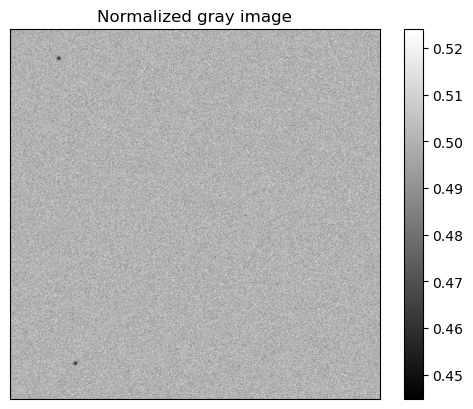

In [21]:
# Calculated parameter below, do not change manually
#--------------------------------------------------
assert_lib_ok()

HEIGHT, WIDTH = SENSOR_SHAPE

class ImageArray(np.ndarray):
    def __new__(cls, input_array, is_valid = True):        
        obj = np.asarray(input_array).view(cls)
        obj.is_valif = is_valid
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.is_valid = getattr(obj, 'is_valid', None)

if SHOT_NOISE == "normal":
    def sensor_image(im):
        """Computes sensor repsonse from the electric field"""
        norm = (2**ADCBIT-1)
        # in case image is complex
        #im = field.real ** 2 + field.imag ** 2
        # electron count image, round to nearest integer
        im = np.round(np.random.normal(loc = im, scale = (im / SENSOR_WELL_CAPACITY)**0.5)*SENSOR_WELL_CAPACITY)
        # ADC conversion. A full well with signal of 1.0 gives max byte value  
        # first scale and clip
        scale = norm / SENSOR_WELL_CAPACITY
        im = clip(im*scale,-0.5,norm+0.5)
        # create digital image by rounding then convert back to float for float representation of the uint image
        im = np.round(im)/norm
        return im

else:
    def sensor_image(im):
        """Computes sensor repsonse from the expected relative image value and sensor window function"""
        norm = (2**ADCBIT - 1)
        #im = field.real ** 2 + field.imag ** 2
        im = np.random.poisson(np.abs(im)*SENSOR_WELL_CAPACITY)
        scale = norm / SENSOR_WELL_CAPACITY
        im = clip(im*scale,-0.5,norm+0.5)
        im = np.round(im)/norm
        return im

if USENUMBA:
    # make a numba-optimized function.
    sensor_image = nb.vectorize([NBFLOAT(NBFLOAT)], target = NBTARGET, fastmath = NBFASTMATH)(sensor_image)

def spot(shape = SENSOR_SHAPE, dtype = FDTYPE, center = (0,0), diameter = 4, attenuation = 0.1):
    h,w = shape 
    yn = np.fft.fftfreq(h,d = 1/h)
    xn = np.fft.fftfreq(w,d = 1/w)
    y,x = np.meshgrid(yn,xn, indexing = 'ij')
    y0,x0 = center
    sigma = diameter / (8*np.log(2))**0.5 #sigma from full width half maximum (diameter)
    window = 1. - attenuation*np.exp(-((x-x0)**2 + (y-y0)**2)/2/sigma**2)
    return np.asarray(window, dtype)

def blackman(shape = SENSOR_SHAPE, dtype = FDTYPE):
    """Returns a Blackman window function"""
    h,w = shape
    
    yn = np.fft.fftfreq(h,d = 1/h)
    xn = np.fft.fftfreq(w,d = 1/w)
    y,x = np.meshgrid(yn,xn, indexing = 'ij')

    phase = np.sqrt((2*np.pi*x/w)**2 + (2*np.pi*y/h)**2)
    mask = np.abs(phase) > np.pi
    window = (np.cos(phase)+1)/2
    window[mask] = 0.
    window = np.asarray(np.fft.fftshift(window), dtype)
    return window

def ones(shape = SENSOR_SHAPE, dtype = FDTYPE):
    """Returns a noisless bright sensor image aray"""
    return np.ones(shape, dtype)

def zeros(shape = SENSOR_SHAPE, dtype = FDTYPE):
    """Returns a noisless dark sensor image aray"""
    return np.zeros(shape, dtype)

def print_camera_settings():
    print("Camera settings")
    print_line("-")
    #print(f"Count (number of frames):   {COUNT}")
    #print(f"Camera FPS:                 {FPS}")
    #print(f"Total measurement time:     {COUNT/FPS:.1f} s")
    print(f"Sensor shape:               {SENSOR_SHAPE}")
    print(f"Pixel size:                 {PIXELSIZE*1e6} um")
    print(f"Relative exposure level:    {EXPOSURE_LEVEL*100} %")
    print(f"Sensor full well capacity:  {SENSOR_WELL_CAPACITY} e-")
    print(f"Shot noise type:            '{SHOT_NOISE}'")
    print(f"ADC resolution:             {ADCBIT}bit")
    #print(f"Magnification factor:       {MAGNIFICATION}x")
    #print(f"Lens numerical aperture:    {NA}")
    #print(f"Illimination wavelength:    {WAVELENGTH*1e9} nm")
    print_line("=")

def assert_camera_ok():
    """Whether camera settings are all set"""
    assert_lib_ok() 
    assert _CAMERA_OK

dust1 = spot(center = (40,67)) * spot(center = (-50,90))
dust2 = spot(center = (80,27)) * spot(center = (-80,90))

print_camera_settings()

im = sensor_image(ones()*EXPOSURE_LEVEL * dust1)

plt.imshow(im,cmap = "gray")

plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("Normalized gray image")

print("Expected mean", EXPOSURE_LEVEL)
print("Measured mean", im.mean())
print("Expected STD", (np.sqrt(EXPOSURE_LEVEL * SENSOR_WELL_CAPACITY)/SENSOR_WELL_CAPACITY))
print("Measured STD", im.std())

_CAMERA_OK = True

### Microscope settings

Here we define optical microscope settings. This includes the objective lens, the Koehler illumination setup, and the spectral properties of the illuminant. These settings are for the particle imaging simulations. In the simulations, we assume that the condenser NA is low, so this parameter should be much lower than 1, whereas the objective NA can be higher than 1 (immersion objectivces)

In [22]:
#: microscope magnification factor
MAGNIFICATION = 60.

#: Objective lens numerical aperture
OBJECTIVE_NA = 0.9

#: Objective lens numerical aperture
CONDENSER_NA = 0.15

#: Illumination central wavelength
WAVELENGTH = 5.5e-7 #m

#: illuminant FWHM 
BANDWIDTH = 28e-9 #m

#: how many points are being used for illuminant specter
NUM_WAVELENGTHS = 31

# ligh source power in Watts (not used)
POWER = 1

_MICROSCOPE_OK = False

Microscope settings
------------------------------------------------------------------------
Magnification factor:         60.0x
Objective numerical aperture: 0.9
Condenser numerical aperture: 0.15
Source nominal wavelength:    550.0 nm
Source bandwidth:             28.0 nm


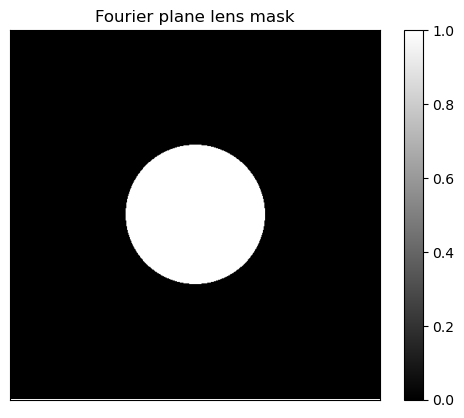

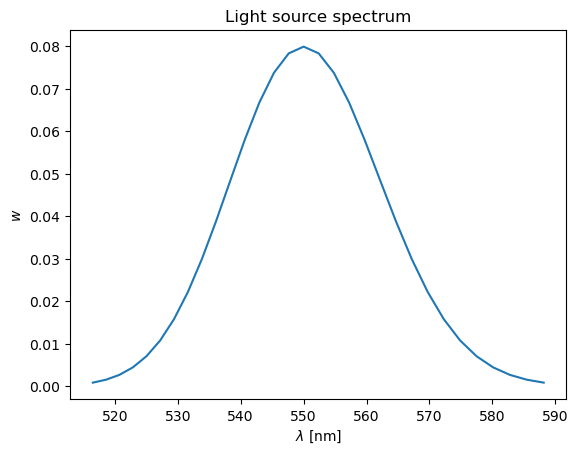

In [23]:
# Calculated parameter below, do not change manually
#--------------------------------------------------

assert_camera_ok()

#: calcualted x step vector (real space unit size) 
XSTEP = (PIXELSIZE/MAGNIFICATION, PIXELSIZE/MAGNIFICATION) # meters

#: calculated k step vector (reciprocal space unit size)
KSTEP = (2*np.pi/SENSOR_SHAPE[0]/XSTEP[0], 2*np.pi/SENSOR_SHAPE[1]/XSTEP[1]) #inverse meters

#: calculated central wave number
K0 = 2*np.pi/WAVELENGTH 

#: sigma of the gaussian computed from the bandwidth and central wavelengths
K0_SIGMA = (2*np.pi/(WAVELENGTH - BANDWIDTH/2) - 2*np.pi/(WAVELENGTH + BANDWIDTH/2))/(np.sqrt(8 * np.log(2)))

K0S = np.linspace(K0-K0_SIGMA*3, K0+K0_SIGMA*3, NUM_WAVELENGTHS)

WAVELENGTHS = np.pi*2/K0S

HEIGHT, WIDTH = SENSOR_SHAPE

# Intensity at the sample. Assuming all power illuminates the viewing area
INTENSITY = POWER/(PIXELSIZE/MAGNIFICATION)**2/HEIGHT/WIDTH

_in = np.fft.fftfreq(HEIGHT,d = 1/HEIGHT)
_jn = np.fft.fftfreq(WIDTH, d = 1/WIDTH)

I, J = np.meshgrid(_in,_jn, indexing = 'ij')
I = np.asarray(I,int)
J = np.asarray(J,int)

KI = np.asarray(I * KSTEP[0],FDTYPE)
KJ = np.asarray(J * KSTEP[1],FDTYPE)

KIPIXEL = KI * XSTEP[0]
KJPIXEL = KJ * XSTEP[1]

KPERP2 = KI**2 + KJ**2
KPERP = np.sqrt(KPERP2)

#: reciprocal space mask array
LENS_MASK =  KPERP < K0 * OBJECTIVE_NA

FFT2_MASK = KPERP < K0 * OBJECTIVE_NA 
RFFT2_MASK = FFT2_MASK[:,0:WIDTH//2+1]

RKPERP2 = KPERP2[:,0:WIDTH//2+1]
RKIPIXEL = KIPIXEL[:,0:WIDTH//2+1]
RKJPIXEL = KJPIXEL[:,0:WIDTH//2+1]

#: reciprocal space unitles k vector
KVEC = np.empty(KI.shape + (2,),FDTYPE)
KVEC[...,0] = KI*XSTEP[0]
KVEC[...,1] = KJ*XSTEP[0]

def print_microscope_settings():
    print("Microscope settings")
    print_line("-")
    print(f"Magnification factor:         {MAGNIFICATION}x")
    print(f"Objective numerical aperture: {OBJECTIVE_NA}")
    print(f"Condenser numerical aperture: {CONDENSER_NA}")
    print(f"Source nominal wavelength:    {WAVELENGTH*1e9} nm")
    print(f"Source bandwidth:             {BANDWIDTH*1e9} nm")
    print_line("=")

def assert_microscope_ok():
    assert_camera_ok()
    assert _MICROSCOPE_OK == True

print_microscope_settings()

K_WEIGHTS = np.exp(-(K0S-K0)**2/2/K0_SIGMA**2)
K_WEIGHTS /= K_WEIGHTS.sum()

weights = K_WEIGHTS 

plt.figure()
plt.imshow(np.fft.fftshift(LENS_MASK),cmap = "gray")
plt.title("Fourier plane lens mask")
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.figure()
plt.plot(WAVELENGTHS*1e9,K_WEIGHTS )
plt.xlabel(r"$\lambda$ [nm]") 
plt.ylabel("$w$") 
plt.title("Light source spectrum")

_MICROSCOPE_OK = True

### Sample settings


In [24]:
# Sample parameters for imaging
#------------------------------

#: mean particle diameter
DIAMETER = 3e-7 #m

# water refractive index
N_MEDIUM = 1.33

#: particle refractive ind
N_PARTICLE = 1.6

#: channel thickness
CHANNEL_THICKNESS = 400e-6 #m

#: how many points in z direction
NUM_LAYERS = 2001 

#: focal plane with respect to channel bottom surface. 
FOCUS = 200e-6

#: all possible particle positions inside the capilary.
Z_POSITIONS = np.linspace(-FOCUS, CHANNEL_THICKNESS - FOCUS, NUM_LAYERS)

# internal parameter, do not change
_IMAGING_OK = False
_EXPERIMENT_OK = False
_LUT_OK = False
_SIMULATOR_OK = False


### Imaging with a plane wave

First we compute particle images using plane wave illumination. For each position of the particle within the channel, we compute FFT coefficients of the particle image and build a lookup table (LUT).


In [25]:
# Build FFT LUTs 
assert_microscope_ok()

PIXEL_AREA = (PIXELSIZE/MAGNIFICATION)**2

PARTICLE_AREA = np.pi * (DIAMETER/2)**2

RECIPROCAL_PIXEL_AREA = (WAVELENGTH/(PIXELSIZE/MAGNIFICATION * N_MEDIUM ))**2 / HEIGHT/WIDTH

SURFACE_RATIO = (PARTICLE_AREA/PIXEL_AREA)

def evec(a,b, default_perp = None):
    a = np.asarray(a,dtype = float)
    b = np.asarray(b,dtype = float)
    
    eperp = np.cross(a,b)
    norm = np.sqrt((eperp*eperp).sum(axis = -1))
    mask = norm != 0.
    
    try:
        eperp[mask] /= norm
    except:
        eperp[mask] /= norm[mask][...,None]
    try:
        eperp[np.logical_not(mask)] = default_perp
    except:
        eperp[np.logical_not(mask)] = default_perp[np.logical_not(mask)]
    else:
        pass
    epara = np.cross(a,eperp)
    return epara, eperp

ez = np.asarray((0,0,1),FDTYPE)
ex = np.asarray((1,0,0),FDTYPE)
ey = np.asarray((0,1,0),FDTYPE)

def compute_modes(k0, input_mask = None, out = None):
    beta = KPERP / k0
    mask = beta < OBJECTIVE_NA
    
    phi = np.arctan2(KJ[mask],KI[mask])
    
    cosphi = np.cos(phi)
    #cosphi2 = cosphi**2
    sinphi = np.sin(phi)
    #sinphi2 = sinphi**2
    #cosphi_sinphi = cosphi* sinphi

    sintheta = beta[mask]/N_MEDIUM
    theta = np.arcsin(sintheta)

    # wavenumber 
    k = k0*N_MEDIUM

    k2 = k**2-KPERP2[mask]

    svec = np.zeros(shape = beta.shape + (3,), dtype = FDTYPE)
    svec[mask,0] = cosphi * sintheta
    svec[mask,1] = sinphi * sintheta
    svec[mask,2] = np.cos(theta)

    # the scattered wave unit vectors
    s = svec[mask]
    
    # input wave propagation direction
    if input_mask is not None:
        ps = svec[input_mask]
        # cosine for mie calculator
        mu = dot(ps[:,None,:],s)
    else:
        ps = svec[0,0]
        # cosine for mie calculator
        mu = dot(ps,s)

    #if out is None:
    #    out = np.empty(shape = (len(ps),len(s)),dtype = CDTYPE)
        
    #s1 = out
    #s2 = np.empty(shape = (len(ps),len(s)),dtype = CDTYPE) 

    wavelength = 2*np.pi/k0
    # environment wavelength
    wn = wavelength / N_MEDIUM 
    # relative particle size
    x = np.pi * DIAMETER / wn 
    # relative refractive index
    m = N_PARTICLE / N_MEDIUM 

    # computes mie coefficients 
    s1, s2 = mie.S1_S2(np.asarray(m,"float32"), np.asarray(x,"float32"), np.asarray(mu,"float32"), norm = "qsca" )

    # sum out
    ssum = np.add(s1,s2, out = s1)

    # cosine correction factor for input wave
    fcos0 = 1/np.sqrt(dot(ps,ez))
    
    # cosine correction factor for output wave
    fcos1 = 1/np.sqrt(dot(s,ez))

    RECIPROCAL_PIXEL_AREA = (wavelength/(PIXELSIZE/MAGNIFICATION * N_MEDIUM ))**2 / HEIGHT/WIDTH
    fact = np.sqrt(RECIPROCAL_PIXEL_AREA * SURFACE_RATIO)*(1j)    

    # output wave scale factor
    scale = fcos1*fact/2

    if input_mask is not None:
        # apply axis
        out = np.multiply(fcos0[:,None],scale, out = s2)
    else:
        out = np.multiply(fcos0,scale, out = s2)
    out = np.multiply(out, ssum, out = out)
    # if (polarizer, analyzer) == ("v","h") or (polarizer, analyzer) == ("h","v"):
    #    s = (-cosphi_sinphi * s2 + cosphi_sinphi * s1)
    # elif polarizer == "h" or analyzer == "h": 
    #    s = cosphi2 * s2 + sinphi2 * s1
    # elif polarizer == "v" or analyzer == "v": 
    #    s = sinphi2 * s2 + cosphi2 * s1
    # else:
    #    s = (s1+s2)/2
    
    return mask, out
    
def compute_field(mask, modes, k0, z, input_mask = None, out = None):
    k = k0*N_MEDIUM
    k2 = k**2-KPERP2[mask]
    phase = np.exp(1j*np.sqrt(k2)*z) 

    E = fill_vec(mask,modes*phase, out = out)

    k = k0*N_MEDIUM
    k2 = k**2-KPERP2[input_mask]
    phase = np.exp(1j*np.sqrt(k2)*z) 

    ii = I[input_mask]
    jj = J[input_mask]

    for i,mode in enumerate(modes):
        E[i,ii[i],jj[i]] -= 1j*np.sqrt(HEIGHT*WIDTH) * phase[i]
        
    E = fft2(E, norm = "ortho", workers = 10, overwrite_x = True)
        
    return E

def compute_image(mask, modes, k0, z, input_mask = None):
    k = np.asarray(k0*N_MEDIUM,FDTYPE)
    k2 = np.asarray(k**2-KPERP2[mask],FDTYPE)

    phase = expj(np.asarray(np.sqrt(k2)*z,FDTYPE))
    #phase = np.exp(1j*np.sqrt(k2)*z) 

    k = k0*N_MEDIUM

    if input_mask is not None:
        k2 = k**2-KPERP2[input_mask]
        phase0 = np.exp(1j*np.sqrt(k2)*z) 
        ii = I[input_mask]
        jj = J[input_mask]
    else:
        k2 = k**2
        phase0 = [np.exp(1j*np.sqrt(k2)*z)]
        ii = [0]
        jj = [0]
        modes = [modes]

    im = None
    ims = None

    out = None

    for i,mode in enumerate(modes):
        out = fill_vec(mask,np.asarray(mode * phase, CDTYPE), out = out)
        out[ii[i],jj[i]] -= 1j*np.sqrt(HEIGHT*WIDTH) * phase0[i]
        out = fft2(out, norm = "ortho", overwrite_x = True, workers = 10)
        im = abs2(out, out = im)
        if i == 0:
            ims = im.copy()
        else:
            ims = np.add(im,ims, out = ims)
        
    return ims

#input_mask = KPERP < K0 * 0.01

#print("num modes", input_mask.sum())

#field0 = 0.

#for i,(w,k0) in enumerate(zip(weights, k0s)):
#    print_progress(i,NUM_WAVELENGTHS)
#    mask, modes = compute_modes(k0,input_mask = input_mask)
#    E = compute_field(mask,modes,k0,0e-6,input_mask )
#    field0 += ((np.abs(E)**2).sum(axis = 0))*w

#fields = np.zeros((len(Z_POSITIONS),HEIGHT,WIDTH),FDTYPE)

#for i,(w,k0) in enumerate(zip(weights, K0S)):
#    input_mask = KPERP < k0 * 0.1
#     mask, modes = compute_modes(k0,input_mask = input_mask)      
#     for j,z in enumerate(zs):
#         print_progress(i*len(zs) + j ,NUM_WAVELENGTHS*len(zs))
#         out = compute_image(mask,modes,k0,z,input_mask)
#         fields[j] += out * (w/input_mask.sum())

# print_progress(NUM_WAVELENGTHS*len(zs) ,NUM_WAVELENGTHS*len(zs))

#input_mask[...] = False
#input_mask[0,0] = True

if _IMAGING_OK == False:

    FFT_LUTS = np.zeros((len(Z_POSITIONS),RFFT2_MASK.sum()),CDTYPE)
    
    print("Building particle FFT LUTs")
    
    for i,(w,k0) in enumerate(zip(weights, K0S)):
        mask, modes = compute_modes(k0)#,input_mask = input_mask)      
        for j,z in enumerate(Z_POSITIONS):
            print_progress(i*len(Z_POSITIONS) + j ,NUM_WAVELENGTHS*len(Z_POSITIONS))
            out = compute_image(mask,modes,k0,z)#,input_mask)
            out = rfft2(out, norm = "ortho", workers = 10)[RFFT2_MASK]
            out *= w
            
            FFT_LUTS[j] += out #(w/input_mask.sum())
    
    print_progress(NUM_WAVELENGTHS*len(Z_POSITIONS) ,NUM_WAVELENGTHS*len(Z_POSITIONS))

_IMAGING_OK = True

def assert_imaging_ok():
    assert_microscope_ok()
    assert _IMAGING_OK == True

Building particle FFT LUTs
|==================================================| 100.0 % Done in  1.2 m


Now we place some particles at different heights within the channel and draw an image from the obtained LUTs.

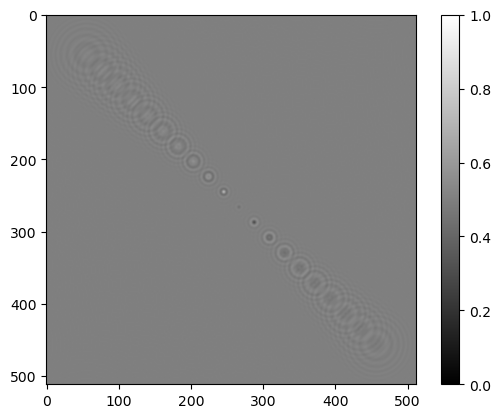

In [26]:
# Draw particles

assert_imaging_ok()

LUT_KI = RKIPIXEL[RFFT2_MASK]
LUT_KJ = RKJPIXEL[RFFT2_MASK]

if USEMLX:
    LUT_KI = mx.array(LUT_KI)
    LUT_KJ = mx.array(LUT_KJ)

# if USECUPY:
#     #Set LUT_KI and LUT_KJ variables as arrays on gpu.
#     LUT_KI =  cp.asarray(LUT_KI)
#     LUT_KJ =  cp.asarray(LUT_KJ)


def _compute(fields,z,ki,kj,xi,xj):
    lut = fields[z]
    phase = ki * xi + kj * xj
    return lut * mx.exp(-1j*phase)

def _compute_coeff_2d(lut,ki,kj,xi,xj):
    phase = ki * xi + kj * xj
    return lut * mx.exp(-1j*phase)

def compute_coeff_2d_mlx(luts,ki,kj,xi,xj):
    out = 0.
    ki = mx.array(ki)
    kj = mx.array(kj)
    xi = mx.array(xi)
    xj = mx.array(xj)   
    luts = mx.array(luts)
    f = mx.vmap(_compute_coeff_2d,in_axes=(0,None,None,0,0))
    out = f(luts,ki,kj,xi,xj)
    out = out.sum(axis = 0)
    mx.eval(out)
    return out

def compute_coeff_2d_cupy(luts,ki,kj,xi,xj):
    
    luts_gpu= cp.asarray(luts)      # shape (N,)
    xi_gpu= cp.asarray(xi)      # shape (N,)
    xj_gpu = cp.asarray(xj)      # shape (N,)
    ki_gpu = cp.asarray(ki)      # shape (M,)
    kj_gpu = cp.asarray(kj)      # shape (M,)
    
    ki_tile_gpu = cp.tile(ki_gpu[:, None], (1, luts_gpu.shape[0]))
    kj_tile_gpu = cp.tile(kj_gpu[:, None], (1, luts_gpu.shape[0]))
    

    phase_mat = xi_gpu*ki_tile_gpu + xj_gpu*kj_tile_gpu
    phase_mat = cp.transpose(phase_mat)
    out_gpu = cp.sum(luts_gpu*cp.exp(-1j*phase_mat), axis=0)     
    
    return out_gpu     #THIS IS A CUPY ARRAY!

def compute_coeff_2d_np(luts,ki,kj,xi,xj):
    out = 0.
    for lut, i,j in zip(luts,xi,xj):
        phase = np.asarray(ki * i + kj * j, FDTYPE)
        out += (lut * expj(-phase))
    return out

def compute_coeff_2d(luts,ki,kj,xi,xj):
    if USEMLX:
        return compute_coeff_2d_mlx(luts,ki,kj,xi,xj)
    elif USECUPY:
        return compute_coeff_2d_cupy(luts,ki,kj,xi,xj) 
    else:
        return compute_coeff_2d_np(luts,ki,kj,xi,xj)
        
def draw_particles_2d(coordinates, luts, exposure = 0.5, ki = LUT_KI, kj = LUT_KJ):
    im = np.zeros(RFFT2_MASK.shape, dtype = CDTYPE)
    xvec = np.asarray(coordinates)
    xi = xvec[:,0]
    xj = xvec[:,1]

    f = compute_coeff_2d(luts,ki,kj,xi,xj)

    if USECUPY:
        im_gpu = cp.asarray(im) 
        im_gpu[RFFT2_MASK] = f * exposure
        im_gpu[0,0] = 0

        return np.abs(_irfft2_cupy(im_gpu, norm = "ortho")+exposure)
        
    else:
        im[RFFT2_MASK] = f * exposure
        im[0,0] = 0
        return np.abs(irfft2(im, norm = "ortho", workers = 10)+exposure)
    # return np.abs(irfft2(im, norm = "ortho", workers = 10)+exposure)
        

# take a subset of FFT_LUTS 
luts = FFT_LUTS[NUM_LAYERS//2-40:NUM_LAYERS//2+40:4]

coordinates = [(i,i) for i in np.linspace(-200,200, len(luts))]
im = draw_particles_2d(coordinates,luts)
plt.imshow(np.fft.fftshift(im), cmap = "gray", vmin = 0, vmax = 1)
plt.colorbar()

### Imaging with Koehler illumination - a simplified model

Here we simulate blurring effect caused by a finite NA of the condenser lens. We modify the planewave LUTs to compute a new LUT applying finite numerical aperture of the illuminant and draw an image.

Applying koehler


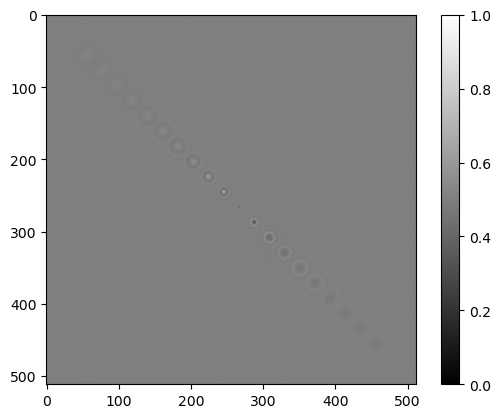

In [27]:
# Apply Koehler illumination
assert_imaging_ok()

def apply_koehler(fim, z = 0,NA = CONDENSER_NA, k2 = RKPERP2[RFFT2_MASK], n = N_MEDIUM):
    return sp.special.hyp0f1(2, -1/4*k2*(z*NA/n)**2)*fim

fft_luts = np.empty_like(FFT_LUTS)

print("Applying koehler")
for j,z in enumerate(Z_POSITIONS):
    fft_luts[j] = apply_koehler(FFT_LUTS[j], z = z)

luts = fft_luts[NUM_LAYERS//2-40:NUM_LAYERS//2+40:4]
coordinates = [(i,i) for i in np.linspace(-200,200, len(luts))]
im = draw_particles_2d(coordinates,luts)
    
plt.imshow(np.fft.fftshift(im), cmap = "gray",vmin = 0,vmax =1)
plt.colorbar()

_LUT_OK = True

def assert_lut_ok():
    assert_imaging_ok()
    assert _LUT_OK == True


## Usage example 

Here, we demonstrate how to use the particle imaging model. First, you must define the depth coordinates in unitless (layer index) units, and you must define the x,y coordinates in pixel units. Then, we use *draw_particles_2d* function to first build the intensity image. Then, we use *sensor_image* to simulate image acquisition performed by a camera, which adds ADC conversion and applies the shot noise. 


Building LUTs
Computing image


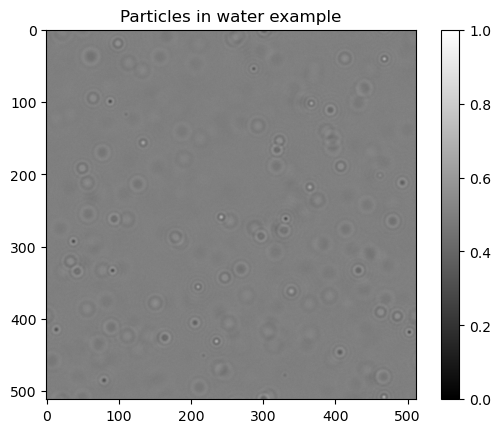

In [28]:
# Usage example
assert_lut_ok() #make sure we have lookup tables

#: how many particles in the viewing area
NUM_PARTICLES = 4000

def initial_zs():
    """Returns randomized initial particle z coordinates in layer thickness units"""
    return np.asarray(np.random.rand(NUM_PARTICLES) * NUM_LAYERS, np.int64)

def initial_coordinates():
    """Returns randomized initial particle (x,y) coordinates in pixel units"""
    return np.random.rand(NUM_PARTICLES,2) * np.asarray((HEIGHT, WIDTH))

particle_zs = initial_zs()
particle_xs = initial_coordinates()

print("Building LUTs")   
luts = fft_luts[particle_zs]

if USEMLX:
    #convert to mx.array, so that it is faster
    luts = mx.array(luts)
elif USECUPY:
    luts = cp.array(luts)

print("Computing image")
im = draw_particles_2d(particle_xs,luts)
    
plt.imshow(np.fft.fftshift(sensor_image(im)), cmap = "gray", vmin = 0, vmax = 1)
plt.title("Particles in water example")
plt.colorbar()
if SAVE_FIGS:
    plt.savefig("particles.png")

### Test image calculation speed

We really need GPU to compute these fast

In [29]:
timeit draw_particles_2d(initial_coordinates(),luts)

264 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
